# Title & Overview
## Implementation of PCA with ANN algorithm for Face recognition
We reduce face-image dimensionality using PCA, then train an ANN (MLP) for classification, with visualization, tuning, and saving.

### Imports
Load all libraries for data handling, PCA, ANN training, metrics, and image I/O.

In [9]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.io import imread
from skimage.transform import resize

# Optional: nicer plots
sns.set(context="notebook", style="whitegrid")


### Load custom dataset
Each person has a folder; folder name = class label. All images are resized and flattened.

In [12]:
# Config: change these to your paths/sizes
dataset_path = "dataset"   # e.g., dataset/person1/*.jpg
image_size   = (50, 37)    # (H, W) — adjust to your dataset

X = []
y = []
target_names = []

print("📥 Loading images from:", dataset_path)

for label, person_name in enumerate(sorted(os.listdir(dataset_path))):
    person_dir = os.path.join(dataset_path, person_name)
    if not os.path.isdir(person_dir):
        continue
    target_names.append(person_name)
    for img_file in os.listdir(person_dir):
        img_path = os.path.join(person_dir, img_file)
        if not img_file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        try:
            img = imread(img_path, as_gray=True)
            img_resized = resize(img, image_size, anti_aliasing=True)
            X.append(img_resized.flatten())
            y.append(label)
        except Exception as e:
            print(f"⚠️ Could not read {img_path}: {e}")

X = np.array(X)
y = np.array(y)
image_shape = image_size
n_classes = len(target_names)

print(f"✅ Loaded {len(X)} images across {n_classes} classes.")


📥 Loading images from: dataset
✅ Loaded 450 images across 9 classes.


### Train/Test Split

#### Split data
Use 75% for training and 25% for testing with a fixed random seed.

In [15]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y if n_classes > 1 else None
)
print(f"Train: {x_train.shape}, Test: {x_test.shape}")


Train: (337, 1850), Test: (113, 1850)


### PCA

#### Dimensionality reduction
Apply PCA (with whitening) to compress features while retaining most variance.

In [18]:
pca = PCA(n_components=100, whiten=True, random_state=42)
x_train_lda = pca.fit_transform(x_train)
x_test_lda  = pca.transform(x_test)

print(f"Original dims: {X.shape[1]}, PCA dims: {pca.n_components_}")

Original dims: 1850, PCA dims: 100


### PCA Variance Plot

#### Explained variance
Visualize how many components capture 95%+ of the variance.

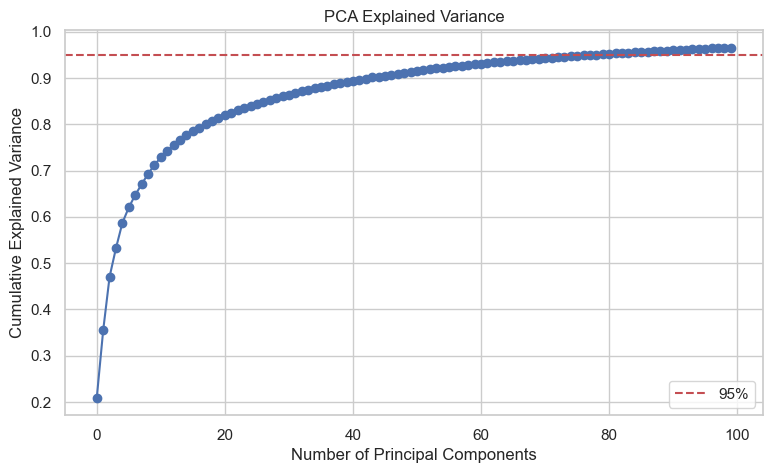

In [21]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(9,5))
plt.plot(cumulative_variance, marker='o')
plt.axhline(0.95, ls='--', color='r', label='95%')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.show()

### PCA Reconstruction Demo

#### Reconstruction check
Compare original vs PCA-reconstructed images to see retained detail.

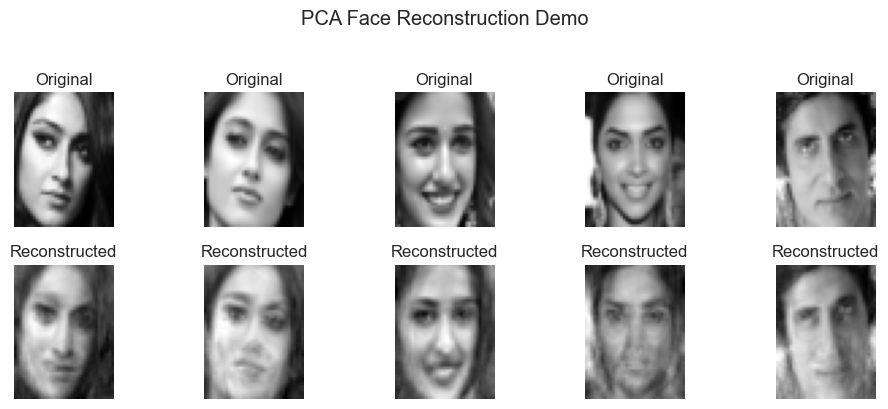

In [44]:
num_faces = min(5, len(x_test))
idxs = np.random.choice(len(x_test), size=num_faces, replace=False)

x_test_pca = pca.transform(x_test[idxs])
x_test_rec = pca.inverse_transform(x_test_pca)

plt.figure(figsize=(10, 4))
for i, idx in enumerate(idxs):
    # Original
    plt.subplot(2, num_faces, i+1)
    plt.imshow(x_test[idx].reshape(image_shape), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    # Reconstructed
    plt.subplot(2, num_faces, num_faces+i+1)
    plt.imshow(x_test_rec[i].reshape(image_shape), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.suptitle("PCA Face Reconstruction Demo", y=1.02)
plt.tight_layout()
plt.show()


### ANN: Tuning + Training + Evaluation

#### Train ANN with tuning
Use GridSearchCV to pick best MLP settings, then evaluate on test set.

🔍 Running GridSearchCV...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

✅ Best Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (150,), 'learning_rate_init': 0.01}
✅ Best CV Score: 0.6292404129793511

🎯 Test Accuracy: 0.7345

📄 Classification Report:
               precision    recall  f1-score   support

       Aamir       0.64      0.75      0.69        12
        Ajay       0.83      0.83      0.83        12
      Akshay       0.69      0.69      0.69        13
        Alia       0.64      0.54      0.58        13
     Amitabh       1.00      0.85      0.92        13
     Deepika       0.71      0.83      0.77        12
       Disha       0.75      0.69      0.72        13
      Farhan       0.91      0.83      0.87        12
      Ileana       0.53      0.62      0.57        13

    accuracy                           0.73       113
   macro avg       0.75      0.74      0.74       113
weighted avg       0.74      0.73      0.74       113



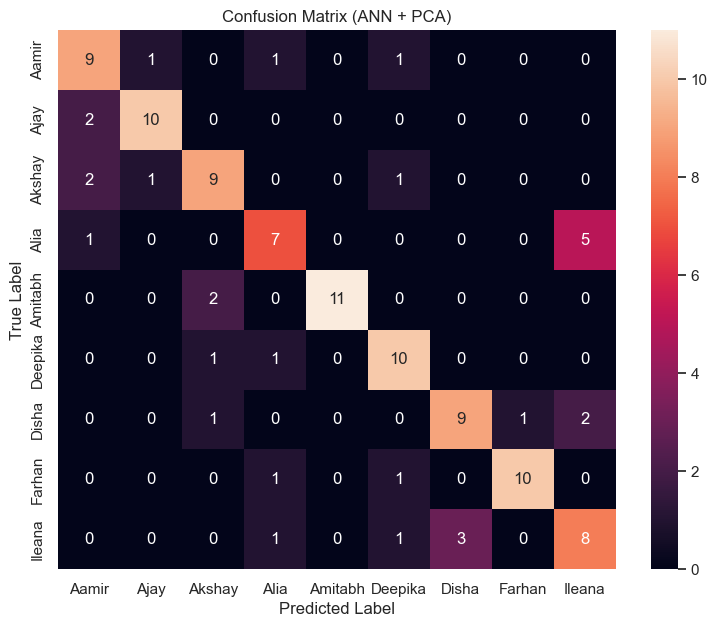

In [27]:
param_grid = {
    'hidden_layer_sizes': [(100,), (150,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

mlp = MLPClassifier(max_iter=500, random_state=42)

grid_search = GridSearchCV(
    mlp, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2
)
print("🔍 Running GridSearchCV...")
grid_search.fit(x_train_lda, y_train)

print("\n✅ Best Parameters:", grid_search.best_params_)
print("✅ Best CV Score:", grid_search.best_score_)

clf = grid_search.best_estimator_

# Evaluate
y_pred = clf.predict(x_test_lda)
acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Test Accuracy: {acc:.4f}")
print("\n📄 Classification Report:\n",
      classification_report(y_test, y_pred, target_names=target_names) if n_classes>1 else
      "Single-class dataset (report not applicable).")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=target_names if n_classes>1 else None,
            yticklabels=target_names if n_classes>1 else None)
plt.title('Confusion Matrix (ANN + PCA)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


### Save Artifacts

#### Save for reuse
Persist the trained model, PCA, and class names to disk.

In [30]:
joblib.dump(clf, "pca_ann_model.pkl")
joblib.dump(pca, "pca_transformer.pkl")
joblib.dump(target_names, "target_names.pkl")
print("💾 Saved: pca_ann_model.pkl, pca_transformer.pkl, target_names.pkl")


💾 Saved: pca_ann_model.pkl, pca_transformer.pkl, target_names.pkl


### Single-Image Prediction

#### Quick test
Load saved model + PCA and predict a single new image.

🎯 Predicted Identity: Aamir


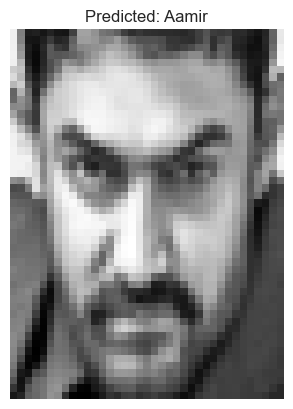

In [39]:
# Load
clf_loaded = joblib.load("pca_ann_model.pkl")
pca_loaded = joblib.load("pca_transformer.pkl")
target_names_loaded = joblib.load("target_names.pkl")

# Change this path to your test image
new_image_path = "Test Faces/Test face - 6.jpg"

# Preprocess -> PCA -> Predict
img = imread(new_image_path, as_gray=True)
img_resized = resize(img, image_shape, anti_aliasing=True)
img_flat = img_resized.flatten().reshape(1, -1)
img_pca = pca_loaded.transform(img_flat)
pred_class = clf_loaded.predict(img_pca)[0]
pred_name = target_names_loaded[pred_class]

print(f"🎯 Predicted Identity: {pred_name}")
plt.imshow(img_resized, cmap='gray')
plt.title(f"Predicted: {pred_name}")
plt.axis('off')
plt.show()


### Batch Prediction

#### Predict a folder
Run prediction on all images in a folder and display results.

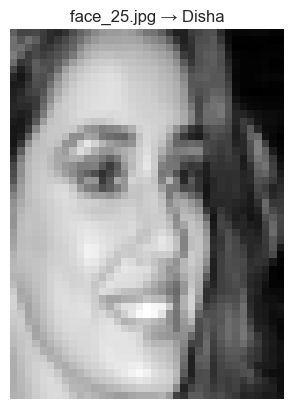

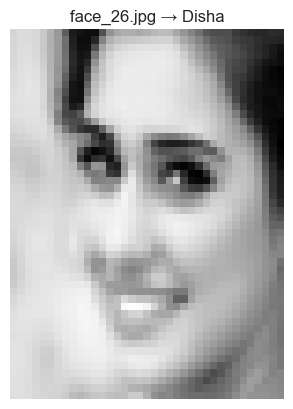

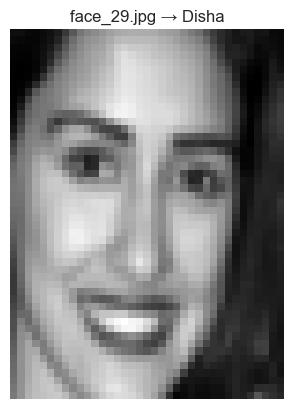

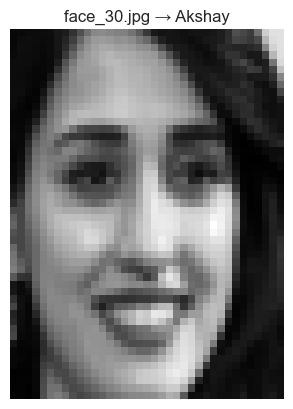

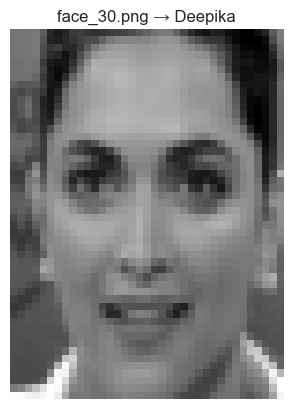

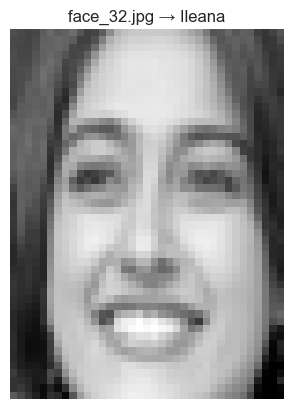

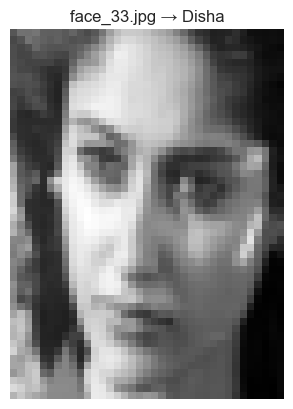

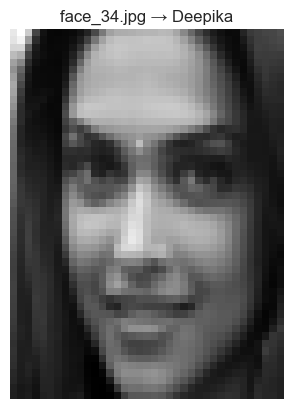

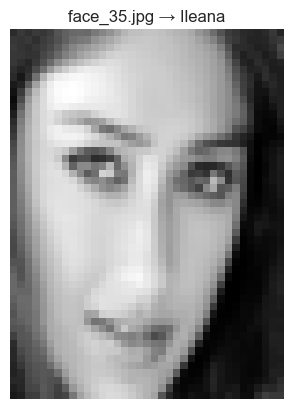

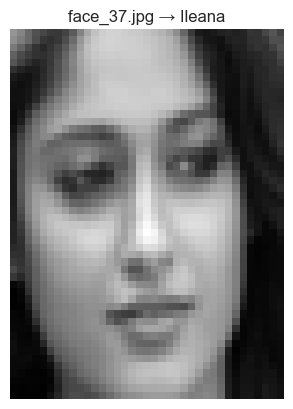

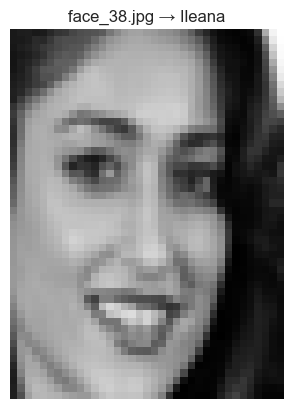

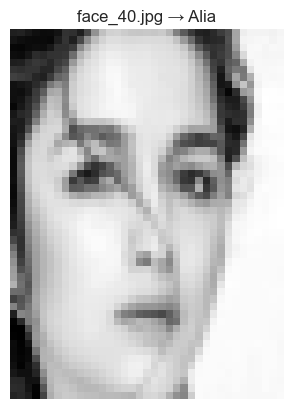

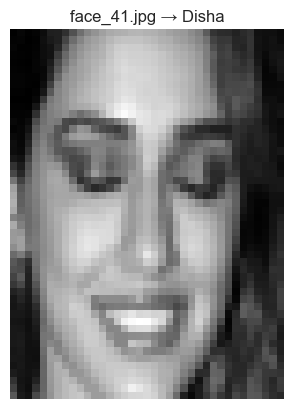

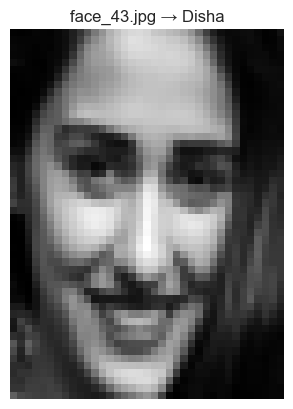

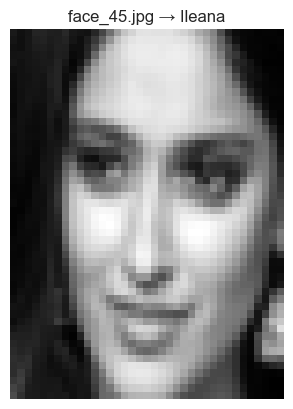

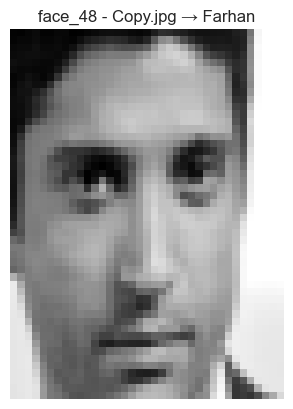

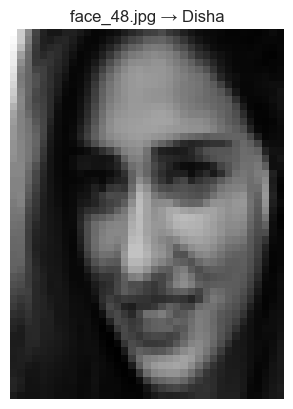

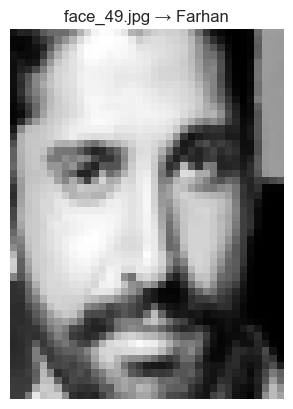

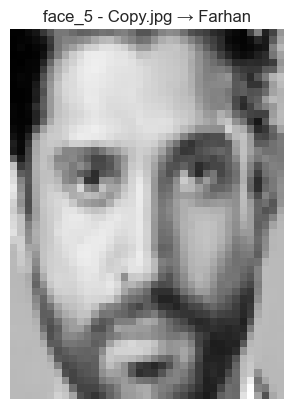

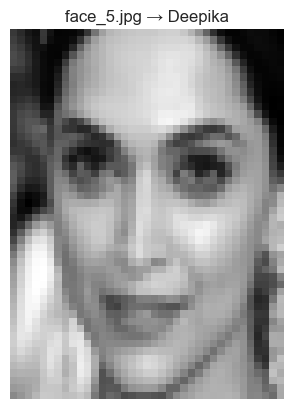

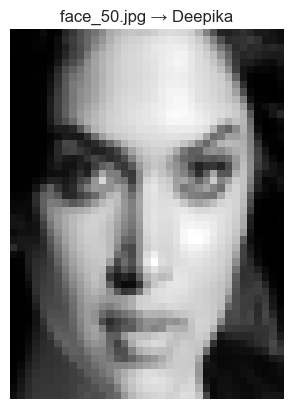

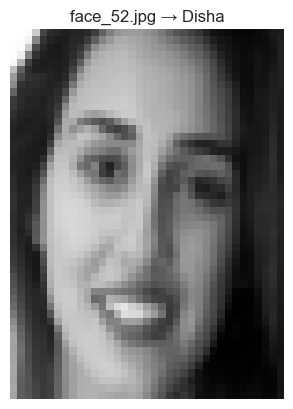

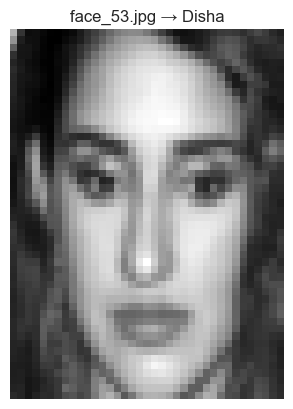

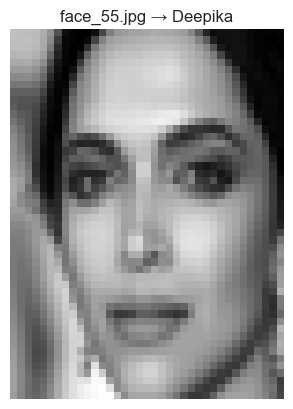

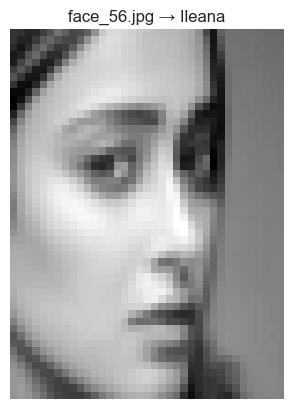

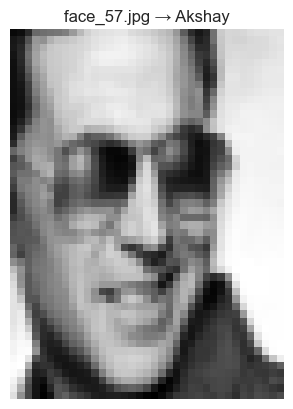

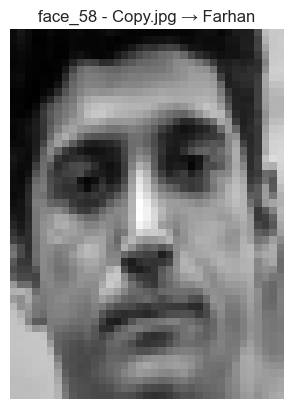

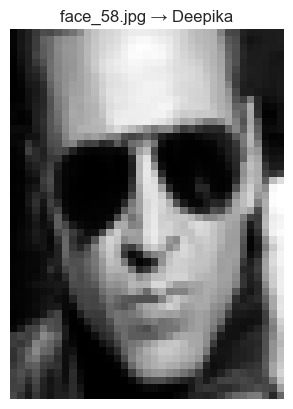

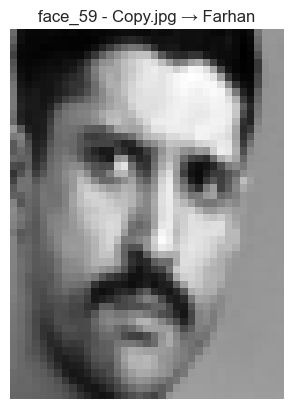

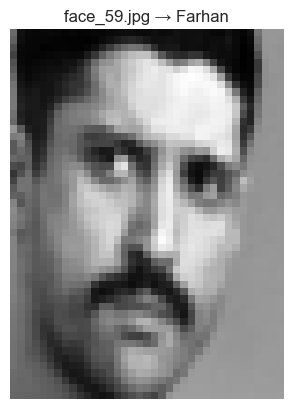

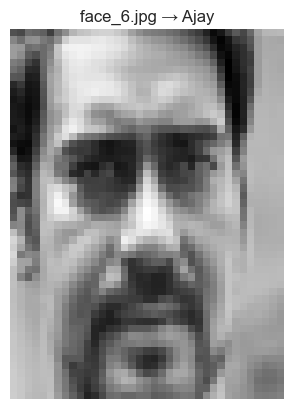

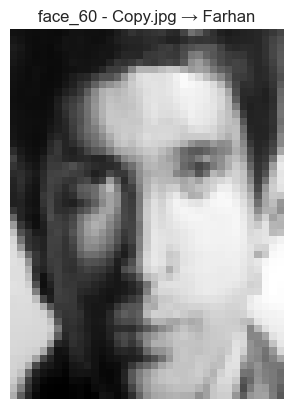

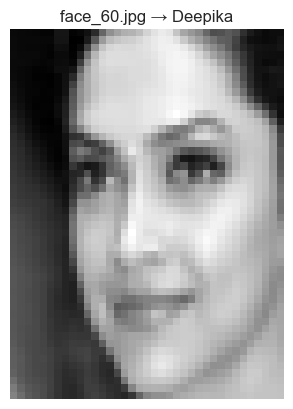

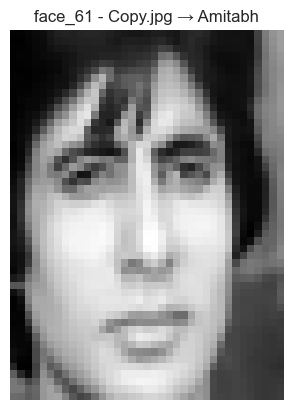

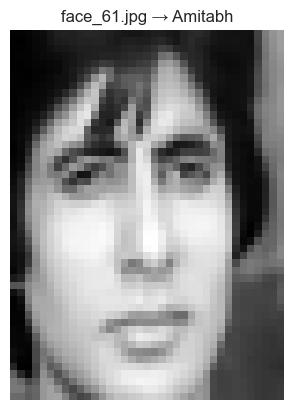

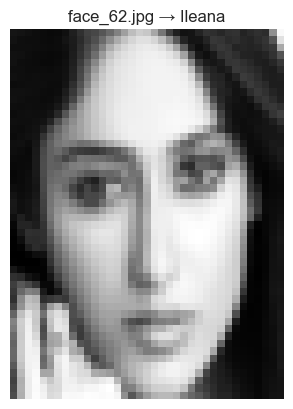

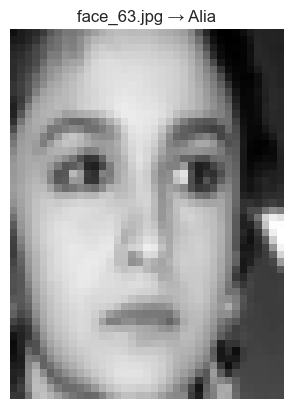

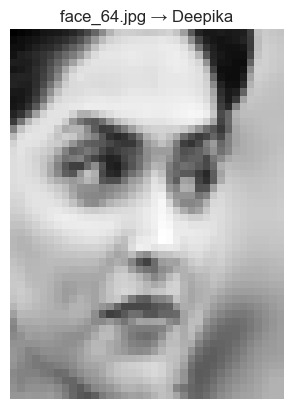

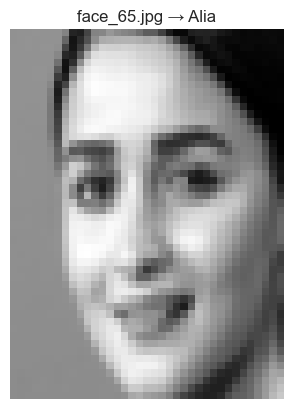

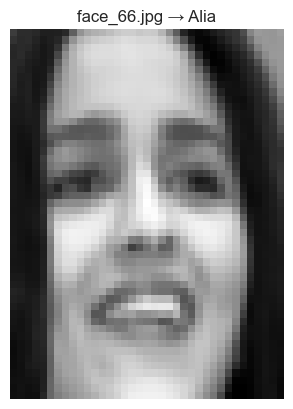

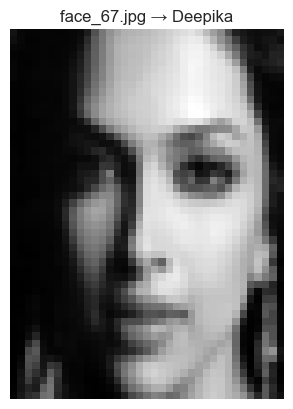

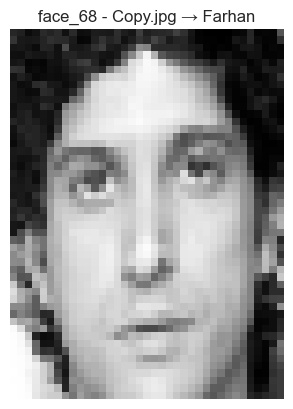

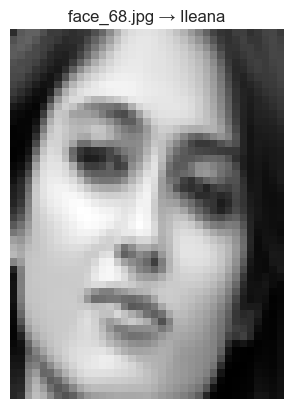

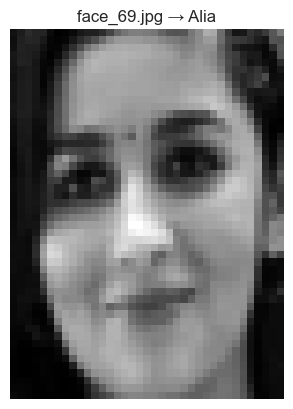

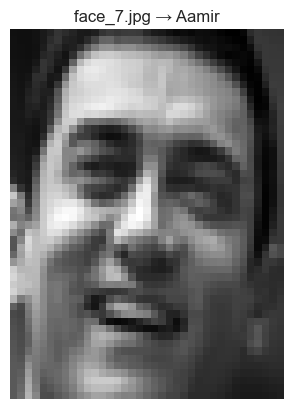

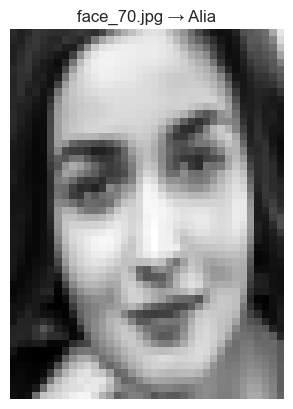

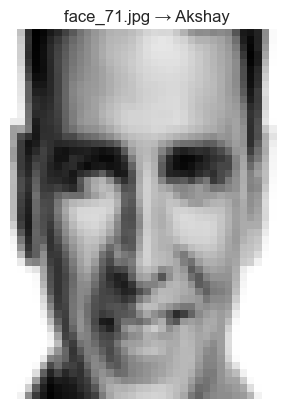

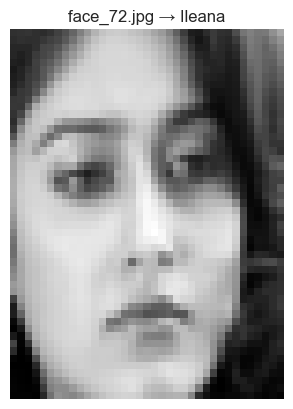

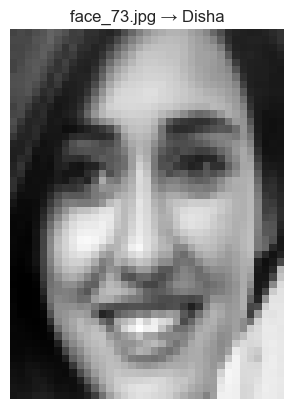

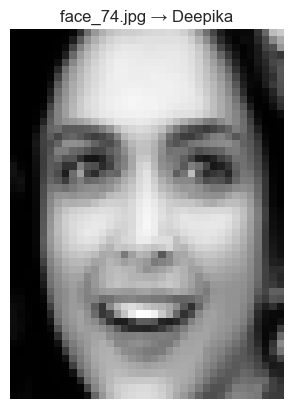

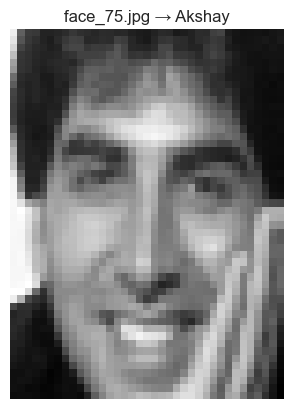

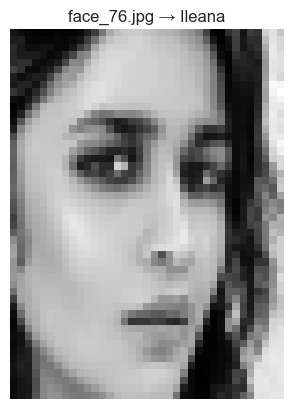

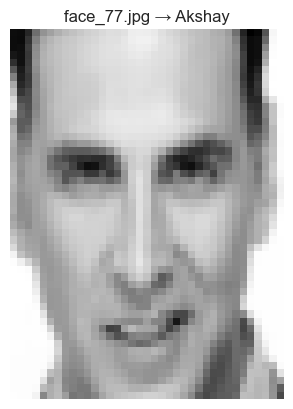

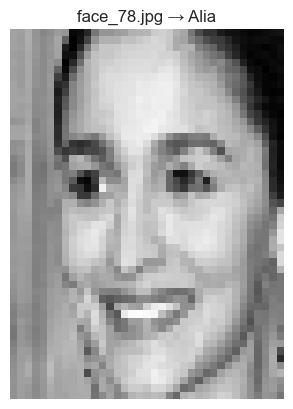

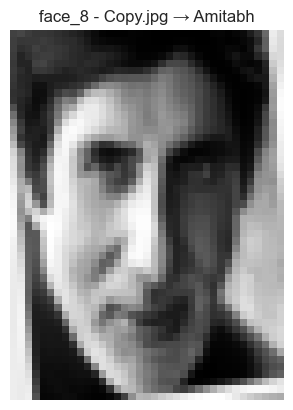

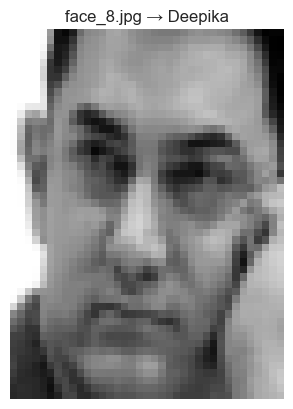

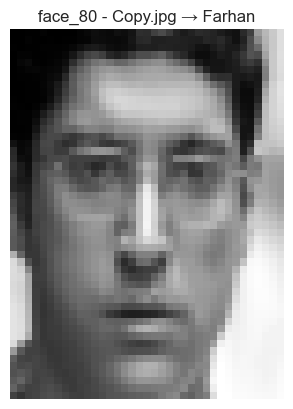

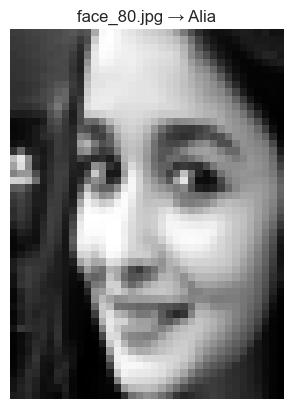

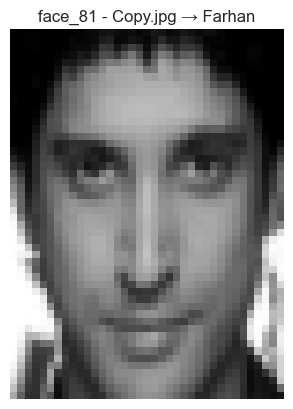

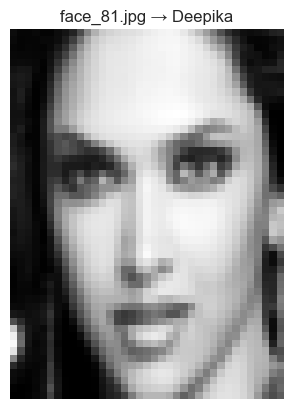

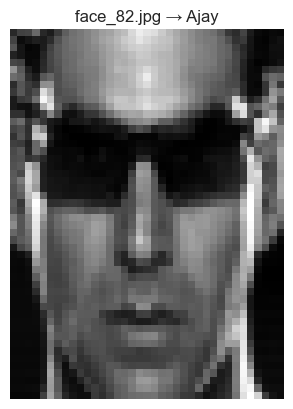

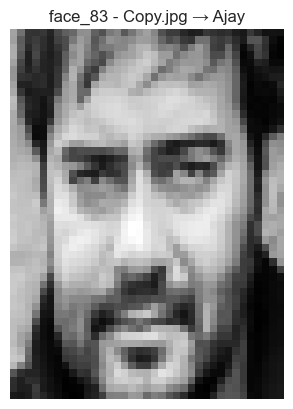

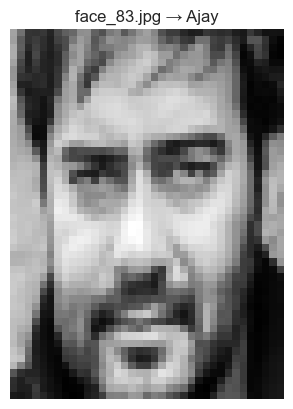

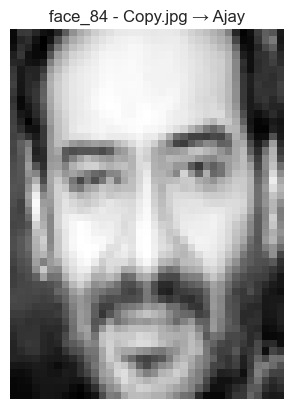

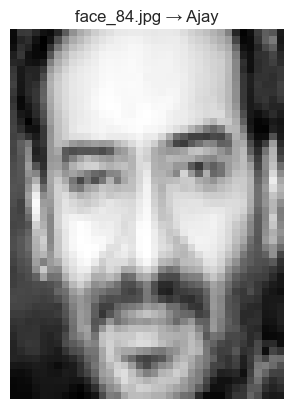

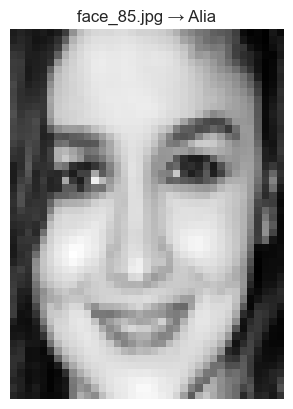

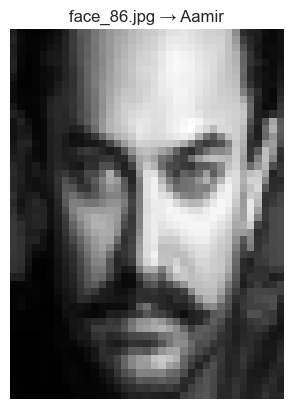

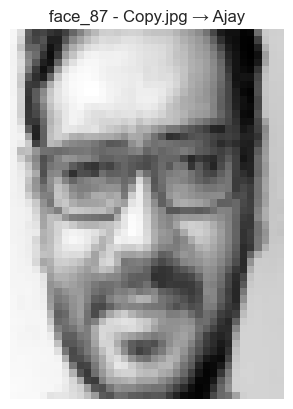

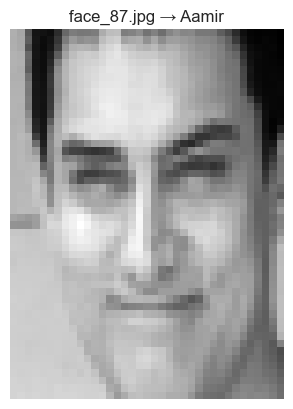

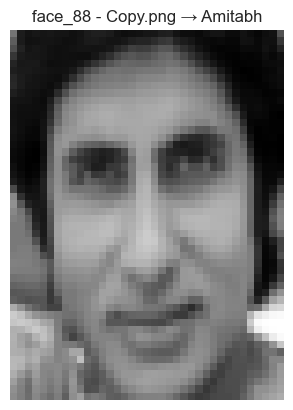

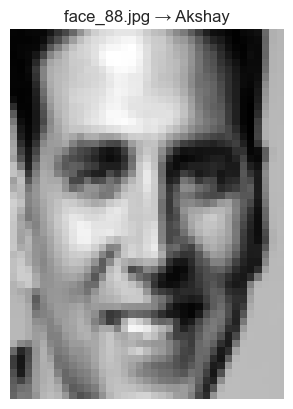

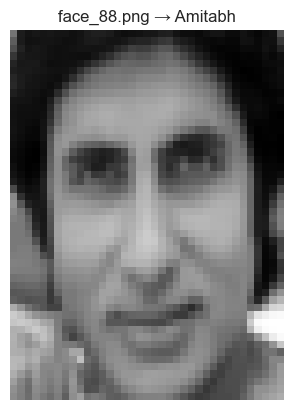

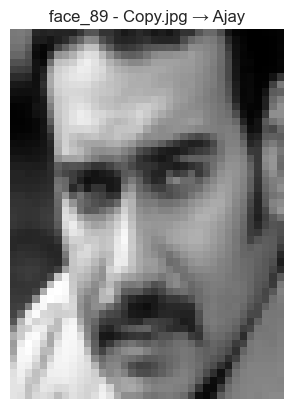

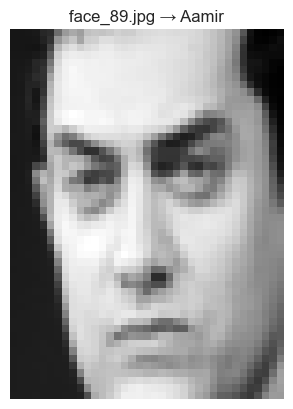

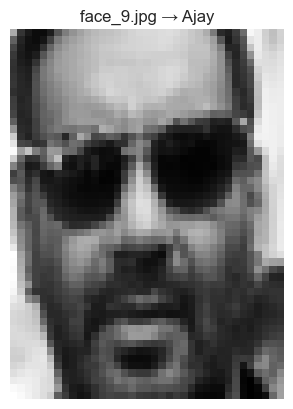

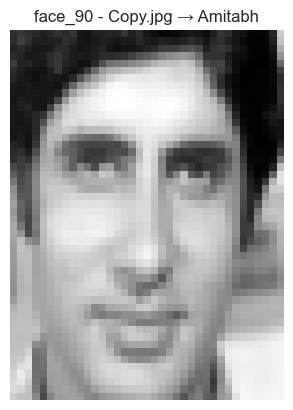

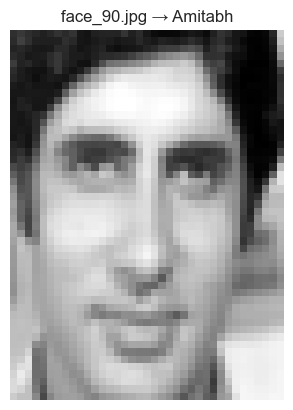

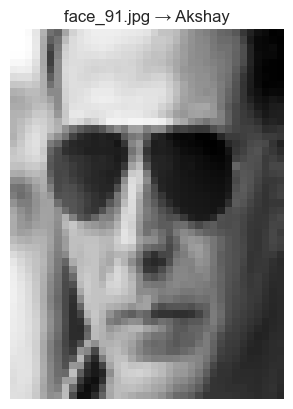

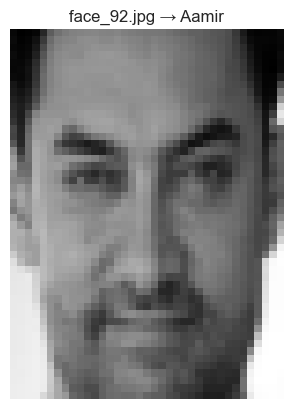

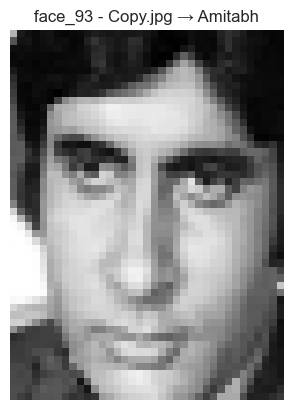

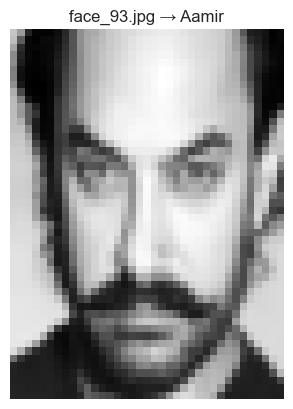

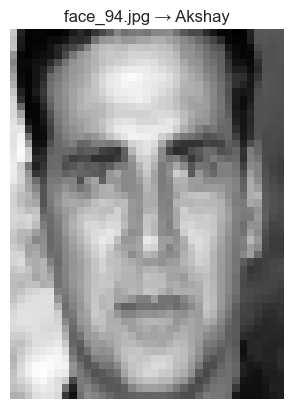

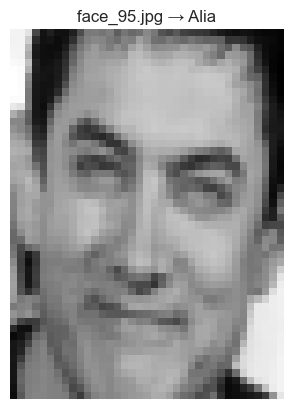

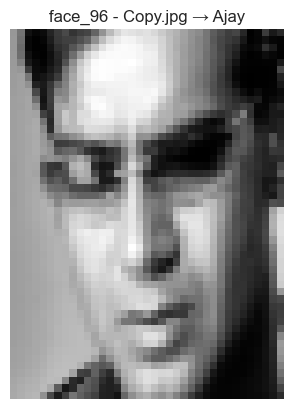

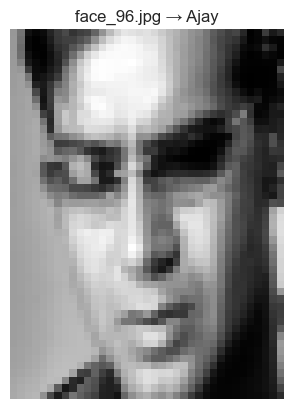

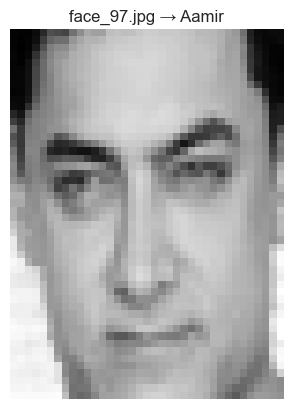

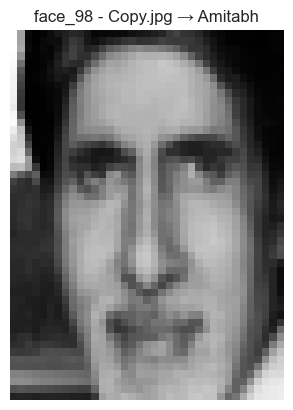

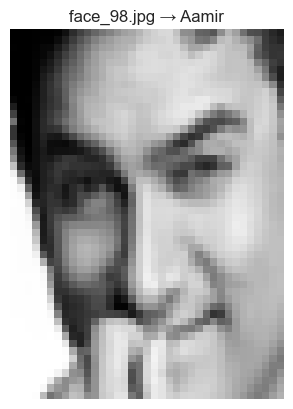

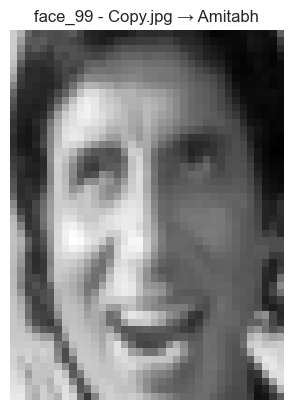

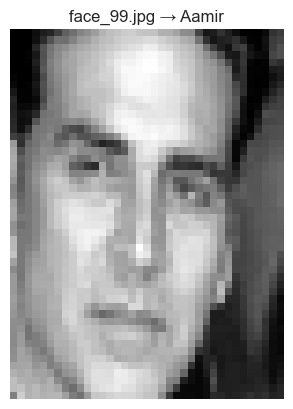


📋 Batch Prediction Results:
face_25.jpg → Disha
face_26.jpg → Disha
face_29.jpg → Disha
face_30.jpg → Akshay
face_30.png → Deepika
face_32.jpg → Ileana
face_33.jpg → Disha
face_34.jpg → Deepika
face_35.jpg → Ileana
face_37.jpg → Ileana
face_38.jpg → Ileana
face_40.jpg → Alia
face_41.jpg → Disha
face_43.jpg → Disha
face_45.jpg → Ileana
face_48 - Copy.jpg → Farhan
face_48.jpg → Disha
face_49.jpg → Farhan
face_5 - Copy.jpg → Farhan
face_5.jpg → Deepika
face_50.jpg → Deepika
face_52.jpg → Disha
face_53.jpg → Disha
face_55.jpg → Deepika
face_56.jpg → Ileana
face_57.jpg → Akshay
face_58 - Copy.jpg → Farhan
face_58.jpg → Deepika
face_59 - Copy.jpg → Farhan
face_59.jpg → Farhan
face_6.jpg → Ajay
face_60 - Copy.jpg → Farhan
face_60.jpg → Deepika
face_61 - Copy.jpg → Amitabh
face_61.jpg → Amitabh
face_62.jpg → Ileana
face_63.jpg → Alia
face_64.jpg → Deepika
face_65.jpg → Alia
face_66.jpg → Alia
face_67.jpg → Deepika
face_68 - Copy.jpg → Farhan
face_68.jpg → Ileana
face_69.jpg → Alia
face_7.jpg 

In [42]:
def batch_predict_images(folder_path):
    results = []
    for img_file in os.listdir(folder_path):
        if not img_file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        img_path = os.path.join(folder_path, img_file)
        try:
            img = imread(img_path, as_gray=True)
            img_resized = resize(img, image_shape, anti_aliasing=True)
            img_flat = img_resized.flatten().reshape(1, -1)
            img_pca = pca_loaded.transform(img_flat)
            pred_class = clf_loaded.predict(img_pca)[0]
            pred_name = target_names_loaded[pred_class]
            results.append((img_file, pred_name))

            plt.imshow(img_resized, cmap='gray')
            plt.title(f"{img_file} → {pred_name}")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"⚠️ Could not process {img_file}: {e}")
    return results

# Change to your folder of test faces
batch_folder = "All Test Faces"
predictions = batch_predict_images(batch_folder)

print("\n📋 Batch Prediction Results:")
for file_name, pred in predictions:
    print(f"{file_name} → {pred}")
